In [1]:
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## read sequence data

In [2]:
SP500=pd.read_csv('data/SP500.csv')
SP500.shape

(13422, 963)

In [50]:
columns=SP500.columns
col=[c for c in columns if '_D' in c]
tickers=[a[6:-2] for a in col]
#del above
col[:10],tickers[:10],len(tickers)

(['test/8_D',
  'train/HD_D',
  'train/DOV_D',
  'test/86_D',
  'train/RTN_D',
  'train/TXT_D',
  'test/37_D',
  'train/BCR_D',
  'train/SBUX_D',
  'train/MCO_D'],
 ['', 'HD', 'DOV', '6', 'RTN', 'TXT', '7', 'BCR', 'SBUX', 'MCO'],
 481)

In [4]:
train_sequences=np.array(SP500.loc[:,col])
train_sequences.shape

(13422, 392)

## Read PCA parameters

In [37]:
eigvec=np.load('data/eigvec.npy')
eigval=np.load('data/eigval.npy')
eigvec.shape, eigval.shape

((481, 481), (481,))

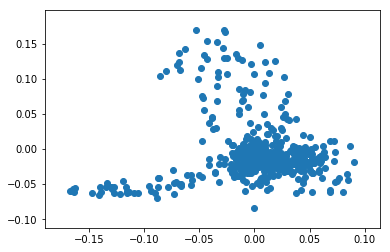

In [40]:
scatter(eigvec[:,2],eigvec[:,1])

## compute features

In [41]:
features=eigvec[:,:20]
features.shape

(481, 20)

##  compute labels (sectors)

In [42]:
TickerInfo=pd.read_csv('data/TickerInfo.tsv',sep='\t')
print(TickerInfo.shape)
TickerInfo.head()

(505, 5)


,Unnamed: 0,Ticker,Name,Sector,SECTOR_ID
0,0,MMM,3M|3M Company,Industrials,INDS
1,1,ABT,Abbott Laboratories,Health Care,HC
2,2,ABBV,AbbVie Inc.,Health Care,HC
3,3,ACN,Accenture plc,Information Technology,IT
4,4,ATVI,Activision Blizzard,Information Technology,IT


In [43]:
Sectors={'Consumer Discretionary':'CD',
 'Consumer Staples':'CS',
 'Energy':'EN',
 'Financials':'FIN',
 'Health Care':'HC',
 'Industrials':'INDS',
 'Information Technology':'IT',
 'Materials':'MAT',
 'Real Estate':'RE',
 'Telecommunication Services':'TS',
 'Utilities':'UTIL'}
sector2number={}
i=0;
for name,short in Sectors.items():
    sector2number[short]=i
    i+=1
sector2number

{'CD': 0,
 'CS': 1,
 'EN': 2,
 'FIN': 3,
 'HC': 4,
 'INDS': 5,
 'IT': 6,
 'MAT': 7,
 'RE': 8,
 'TS': 9,
 'UTIL': 10}

In [44]:
labels=[]
for ticker in tickers:
    answer=list(TickerInfo[TickerInfo.Ticker==ticker]['SECTOR_ID'])
    if len(answer)==1:
        labels.append(sector2number[answer[0]])
    else:
        print('error: could not find sector for ticker:',ticker)

In [45]:
len(labels),len(tickers)

(392, 392)

In [46]:
labels=np.array(labels)
features=features.transpose()
labels.shape,features.shape


((392,), (20, 481))

In [48]:
#this is a case where cross validation can help.

X_train, X_test, y_train, y_test = train_test_split(features.transpose(), labels, test_size=0.30)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

ValueError: Found input variables with inconsistent numbers of samples: [481, 392]

In [14]:
dtrain.num_col(),dtrain.num_row(),dtest.num_col(),dtest.num_row()

(20, 274, 20, 118)

In [28]:
param={}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.3      # shrinkage parameter
param['silent'] = 0     # not silent
param['objective'] = 'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=11
#param['eval_metric'] = ''
num_round=10
plst = param.items()
print(param)
evallist = [(dtrain, 'train'), (dtest, 'eval')]

{'max_depth': 3, 'eta': 0.3, 'silent': 0, 'objective': 'multi:softmax', 'nthread': 7, 'num_class': 11}


In [29]:
bst1000 = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False)

In [30]:
y_pred_1000 = bst1000.predict(dtest, ntree_limit=bst1000.best_ntree_limit, output_margin=True)
y_test = dtest.get_label()

In [31]:
len(y_pred_1000)

118

In [32]:
len(y_test)

118

In [33]:
[np.argmax(pred) for pred in y_pred_1000]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]